# Demo No. 11 - Radial velocities fitting.

Following 2 demos will illustrate, how to proceed in case of the binary system with available radial velocities and photometric data. In this demo, we will focus on radial velocity data fitting using couple of methods.


In [17]:
import numpy as np
import astropy.units as u

from elisa.conf import config
from elisa.analytics import RVData
from elisa.analytics import BinarySystemAnalyticsTask


# setting up a custom logging config to prevent unreasonably long log messages during fit
config.LOG_CONFIG ='jupyter_fit_logging.json'
config.set_up_logging()  

As a start, we will create datasets containing our observations:

In [18]:
rv_primary = RVData.load_from_file(filename='demo_data/rv_data/rv1.dat', 
                                   x_unit=u.d, y_unit=u.km/u.s)

rv_secondary = RVData.load_from_file(filename='demo_data/rv_data/rv2.dat', 
                                     x_unit=u.d, y_unit=u.km/u.s)

As a next step, we will create an `BinarySystemAnalyticsTask`:

In [19]:
task = BinarySystemAnalyticsTask(radial_velocities={'primary': rv_primary, 'secondary': rv_secondary})

This `task` instance now contains `rv_fit` attribute in which our radial velocity fitting methods can be accessed. 

Now we have to define a dictionary containing starting values of a fit. The list of necessary fit parameters depends on which fit approach is used. In `standard` approach, component masses are fitted. On the other side, `community` approach enables to fit the model using mass ratio and parameter a sin(i) which is much more suitable for radial velocity curve fit. List of necessary fit parameters for each approach can be accessed here:

In [20]:
task.rv_fit.FIT_PARAMS_COMBINATIONS

{'standard': ['p__mass',
  's__mass',
  'inclination',
  'eccentricity',
  'argument_of_periastron',
  'gamma',
  'period',
  'primary_minimum_time'],
 'community': ['mass_ratio',
  'asini',
  'eccentricity',
  'argument_of_periastron',
  'gamma',
  'period',
  'primary_minimum_time']}

In case of radial velocities fitting, it is much more suitable to use `community` approach which will in general remove degeneracies in a fittimg model. 

Lets finally define our starting parameters. Starting parameters are listed in form of dictionary that contain name of the variable as a key and values contains dictionary characterizing starting value of the parameter, status of the parameter (`fixed`: True/False), the boundaries of the fitted parameter defined by `min`, `max` values and the unit in astropy format.

In [21]:
rv_initial = {
    'eccentricity': {
        'value': 0.03,
        'fixed': False,
        'min': 0.0,
        'max': 0.05
    },
    'asini': {
        'value': 12,
        'fixed': False,
        'min': 7.0,
        'max': 15,
        'unit': u.solRad
    },
    'mass_ratio': {
        'value': 1.0,
        'fixed': False,
        'min': 0.9,
        'max': 1.2
    },
    'argument_of_periastron': {
        'value': 170,
        'fixed': False,
        'min': 100,
        'max': 240,
        'unit': u.deg
    },
    'gamma': {
        'value': -25.0,
        'fixed': False,
        'min': -10.0,
        'max': -30.0,
        'unit': u.km/u.s
    },
    'period': {
        'value': 2.47028376,
        'fixed': True,
    },
    'primary_minimum_time': {
        'value': 54953.8691,
        'fixed': False,
        'min': 54953.800,
        'max': 54954.000,
        'unit': u.d
    }
}

## Least squares method 

At this point, we can perform actual fit. In current version of Elisa, two fitting methods are available, least-squares and Markov chain Monte Carlo. Lets start with the first one (this may take a few seconds):

In [22]:
fit_params = task.rv_fit.fit(x0=rv_initial, method='least_squares')

2020-02-28 15:41:11,652 - 9258 - analytics.binary.least_squares - INFO: fitting radial velocity light curve...
2020-02-28 15:41:46,764 - 9258 - analytics.binary.least_squares - INFO: fitting finished...
2020-02-28 15:41:46,775 - 9258 - analytics.binary_fit.rv_fit - INFO: Fitting and processing of results succesfully finished.


The resluts of the fitting procedure are stored in `fit_params`:

In [23]:
fit_params

{'eccentricity': {'value': 0.014621063899195964, 'unit': ''},
 'asini': {'value': 11.800520255224722, 'unit': 'solRad'},
 'mass_ratio': {'value': 1.0768512722796373, 'unit': ''},
 'argument_of_periastron': {'value': 220.08763506615372, 'unit': 'degree'},
 'gamma': {'value': -24291.056877061077, 'unit': 'm/s'},
 'primary_minimum_time': {'value': 54953.881016724685, 'unit': 'd'},
 'period': {'value': 2.47028376, 'unit': 'd'},
 'r_squared': {'value': 0.9934356152347638}}

These results can be stored and reloaded in json format using commands `task.rv_fit.store_parameters(filename=)` and `task.rv_fit.load_parameters(filename=)`.

Finally, we can visualize the resulting fit:

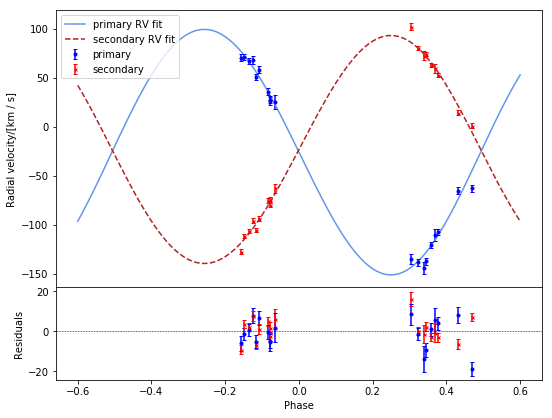

In [24]:
task.rv_fit.plot.model()

## Markov chain Monte Carlo (MCMC)

Using the MCMC we can estimate confidence intervals of the fitted parameters which was not possible in least squares method. Unfortunatelly, this capability is at the expense of speed and therefore this method is meant as a follow-up to the least squares method. To speed-up the initiall burn-in phase, we will update the current initial values to the results obtained in least squares method:

In [25]:
for param in rv_initial.keys():
    rv_initial[param]['value'] = fit_params[param]['value'] 

Updated starting parameters can be now used in a very similar fashion to perform MCMC sampling

In [26]:
fit_params_mcmc = task.rv_fit.fit(x0=rv_initial, method='mcmc', nsteps=1000, progress=True)

2020-02-28 15:42:00,648 - 9258 - analytics.binary.mcmc - INFO: starting singlecore mcmc
2020-02-28 15:42:00,650 - 9258 - analytics.binary.mcmc - INFO: running burn-in...
2020-02-28 15:42:00,669 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11357, likehood = -79.0042914937464
2020-02-28 15:42:00,687 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11358, likehood = -1940.626454567009
2020-02-28 15:42:00,705 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11359, likehood = -293.02845061199764
2020-02-28 15:42:00,723 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11360, likehood = -832.9375327761645
2020-02-28 15:42:00,735 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11361, likehood = -402.4066417893332
2020-02-28 15:42:00,748 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11362, likehood = -1077.9946912758862
2020-02-28 15:42:00,761 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11363, likehood = -801.6560814268273
2020-02-28 15:42:00,774 

  0%|          | 0/100 [00:00<?, ?it/s]

2020-02-28 15:42:00,833 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11369, likehood = -696.3936279679258
2020-02-28 15:42:00,847 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11370, likehood = -92.26972327103147
2020-02-28 15:42:00,858 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11371, likehood = -249.05848727389292
2020-02-28 15:42:00,869 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11372, likehood = -438.587687453152
2020-02-28 15:42:00,880 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11373, likehood = -1636.1851846834807
2020-02-28 15:42:00,893 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11374, likehood = -542.8643901637857
2020-02-28 15:42:00,904 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11375, likehood = -899.3384110025413
2020-02-28 15:42:00,916 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11376, likehood = -213.96469510594008
2020-02-28 15:42:00,929 - 9258 - analytics.binary.mcmc - INFO: eval counter = 

  2%|▏         | 2/100 [00:00<00:07, 12.43it/s]

2020-02-28 15:42:00,998 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11382, likehood = -856.1428692742971
2020-02-28 15:42:01,010 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11383, likehood = -233.52823607351834
2020-02-28 15:42:01,029 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11384, likehood = -724.6825775355995
2020-02-28 15:42:01,047 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11385, likehood = -2004.9261581607464
2020-02-28 15:42:01,059 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11386, likehood = -653.1230082668981
2020-02-28 15:42:01,071 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11387, likehood = -523.5918681969242
2020-02-28 15:42:01,082 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11388, likehood = -235.41344161721085
2020-02-28 15:42:01,094 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11389, likehood = -1639.0640570380608


  3%|▎         | 3/100 [00:00<00:08, 11.11it/s]

2020-02-28 15:42:01,113 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11390, likehood = -289.36340490684415
2020-02-28 15:42:01,125 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11391, likehood = -1081.5868941655149
2020-02-28 15:42:01,136 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11392, likehood = -263.0378317058581
2020-02-28 15:42:01,147 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11393, likehood = -371.4051843468324
2020-02-28 15:42:01,159 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11394, likehood = -92.4556849278105
2020-02-28 15:42:01,170 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11395, likehood = -256.0049588616837
2020-02-28 15:42:01,183 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11396, likehood = -448.1847408653635
2020-02-28 15:42:01,194 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11397, likehood = -596.0118876599819
2020-02-28 15:42:01,204 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1

  4%|▍         | 4/100 [00:00<00:09, 10.42it/s]

2020-02-28 15:42:01,217 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11399, likehood = -112.61391228496105
2020-02-28 15:42:01,235 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11400, likehood = -1189.545375879876
2020-02-28 15:42:01,252 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11401, likehood = -268.6033405180434
2020-02-28 15:42:01,270 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11402, likehood = -336.25222811683375
2020-02-28 15:42:01,287 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11403, likehood = -209.67448302449841
2020-02-28 15:42:01,301 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11404, likehood = -643.1525459886897
2020-02-28 15:42:01,321 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11405, likehood = -225.98493773125853
2020-02-28 15:42:01,332 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11406, likehood = -639.6533199711514
2020-02-28 15:42:01,343 - 9258 - analytics.binary.mcmc - INFO: eval counter 

  5%|▌         | 5/100 [00:00<00:11,  8.36it/s]

2020-02-28 15:42:01,393 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11411, likehood = -1721.9548749608919
2020-02-28 15:42:01,405 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11412, likehood = -218.48563971904923
2020-02-28 15:42:01,417 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11413, likehood = -451.468566161552
2020-02-28 15:42:01,428 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11414, likehood = -138.78753345337293
2020-02-28 15:42:01,443 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11415, likehood = -235.062377517696
2020-02-28 15:42:01,454 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11416, likehood = -235.88263863954057
2020-02-28 15:42:01,465 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11417, likehood = -213.66464101572214
2020-02-28 15:42:01,475 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11418, likehood = -302.24865078462454
2020-02-28 15:42:01,488 - 9258 - analytics.binary.mcmc - INFO: eval counter 

  6%|▌         | 6/100 [00:00<00:10,  8.59it/s]

2020-02-28 15:42:01,502 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11420, likehood = -191.32026566301863
2020-02-28 15:42:01,515 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11421, likehood = -182.98783798195296
2020-02-28 15:42:01,526 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11422, likehood = -313.8169024682561
2020-02-28 15:42:01,536 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11423, likehood = -231.60171519558807
2020-02-28 15:42:01,550 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11424, likehood = -1110.1994553365732
2020-02-28 15:42:01,562 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11425, likehood = -1388.9555764293107
2020-02-28 15:42:01,574 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11426, likehood = -267.6763946758716
2020-02-28 15:42:01,586 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11427, likehood = -263.693835605629
2020-02-28 15:42:01,599 - 9258 - analytics.binary.mcmc - INFO: eval counter 

  7%|▋         | 7/100 [00:00<00:10,  8.46it/s]

2020-02-28 15:42:01,628 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11430, likehood = -1886.027946543595
2020-02-28 15:42:01,639 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11431, likehood = -154.62887780757896
2020-02-28 15:42:01,651 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11432, likehood = -197.536951098891
2020-02-28 15:42:01,663 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11433, likehood = -174.41908043719855
2020-02-28 15:42:01,674 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11434, likehood = -134.03501445590877
2020-02-28 15:42:01,685 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11435, likehood = -157.78597539573607
2020-02-28 15:42:01,697 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11436, likehood = -253.48248810931935
2020-02-28 15:42:01,708 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11437, likehood = -546.3420429551895
2020-02-28 15:42:01,721 - 9258 - analytics.binary.mcmc - INFO: eval counter 

  8%|▊         | 8/100 [00:00<00:11,  8.19it/s]

2020-02-28 15:42:01,754 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11441, likehood = -80.88637545118004
2020-02-28 15:42:01,764 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11442, likehood = -781.4010975394343
2020-02-28 15:42:01,775 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11443, likehood = -281.65115565586206
2020-02-28 15:42:01,789 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11444, likehood = -717.711254361164
2020-02-28 15:42:01,801 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11445, likehood = -368.3430630873885
2020-02-28 15:42:01,814 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11446, likehood = -917.5043626480897
2020-02-28 15:42:01,826 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11447, likehood = -159.69305383262284
2020-02-28 15:42:01,842 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11448, likehood = -236.54229342655518
2020-02-28 15:42:01,854 - 9258 - analytics.binary.mcmc - INFO: eval counter = 

  9%|▉         | 9/100 [00:01<00:11,  7.92it/s]

2020-02-28 15:42:01,890 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11452, likehood = -107.55488837860163
2020-02-28 15:42:01,901 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11453, likehood = -3232.7595219406207
2020-02-28 15:42:01,911 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11454, likehood = -362.49956280742543
2020-02-28 15:42:01,922 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11455, likehood = -160.87711551568083
2020-02-28 15:42:01,933 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11456, likehood = -190.22357575916283
2020-02-28 15:42:01,944 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11457, likehood = -190.1161584191112
2020-02-28 15:42:01,956 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11458, likehood = -135.46911781938448
2020-02-28 15:42:01,969 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11459, likehood = -398.6342912337581
2020-02-28 15:42:01,980 - 9258 - analytics.binary.mcmc - INFO: eval counte

 10%|█         | 10/100 [00:01<00:11,  7.68it/s]

2020-02-28 15:42:02,030 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11464, likehood = -1350.7723734865665
2020-02-28 15:42:02,041 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11465, likehood = -129.6015897132256
2020-02-28 15:42:02,053 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11466, likehood = -635.2579594516137
2020-02-28 15:42:02,064 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11467, likehood = -365.9194670397707
2020-02-28 15:42:02,076 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11468, likehood = -184.73912423394154
2020-02-28 15:42:02,087 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11469, likehood = -135.7196220590006
2020-02-28 15:42:02,100 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11470, likehood = -193.07005610643304
2020-02-28 15:42:02,111 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11471, likehood = -346.03794916707494
2020-02-28 15:42:02,122 - 9258 - analytics.binary.mcmc - INFO: eval counter 

 11%|█         | 11/100 [00:01<00:11,  7.74it/s]

2020-02-28 15:42:02,158 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11475, likehood = -84.36702476357814
2020-02-28 15:42:02,172 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11476, likehood = -499.74751888638207
2020-02-28 15:42:02,183 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11477, likehood = -251.1721454141934
2020-02-28 15:42:02,193 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11478, likehood = -335.8786094184154
2020-02-28 15:42:02,206 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11479, likehood = -294.3011237107338
2020-02-28 15:42:02,223 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11480, likehood = -140.4980283227547
2020-02-28 15:42:02,234 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11481, likehood = -125.72187079177267
2020-02-28 15:42:02,244 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11482, likehood = -502.3129686538337
2020-02-28 15:42:02,255 - 9258 - analytics.binary.mcmc - INFO: eval counter = 

 12%|█▏        | 12/100 [00:01<00:11,  7.36it/s]

2020-02-28 15:42:02,310 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11487, likehood = -84.92813349622604
2020-02-28 15:42:02,322 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11488, likehood = -1922.647197699002
2020-02-28 15:42:02,337 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11489, likehood = -126.31339688429826
2020-02-28 15:42:02,351 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11490, likehood = -377.63951416429035
2020-02-28 15:42:02,364 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11491, likehood = -134.12406203904425
2020-02-28 15:42:02,381 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11492, likehood = -108.89908935367009
2020-02-28 15:42:02,393 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11493, likehood = -168.2252787272541
2020-02-28 15:42:02,404 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11494, likehood = -334.734854549372
2020-02-28 15:42:02,415 - 9258 - analytics.binary.mcmc - INFO: eval counter =

 13%|█▎        | 13/100 [00:01<00:12,  7.10it/s]

2020-02-28 15:42:02,459 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11499, likehood = -467.7479921324969
2020-02-28 15:42:02,470 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11500, likehood = -132.58605498854016
2020-02-28 15:42:02,480 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11501, likehood = -138.08402676135034
2020-02-28 15:42:02,494 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11502, likehood = -107.9333517190203
2020-02-28 15:42:02,504 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11503, likehood = -246.49881173095142
2020-02-28 15:42:02,514 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11504, likehood = -140.22439687954176
2020-02-28 15:42:02,525 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11505, likehood = -85.04060805678803
2020-02-28 15:42:02,537 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11506, likehood = -310.7292369472596
2020-02-28 15:42:02,549 - 9258 - analytics.binary.mcmc - INFO: eval counter 

 14%|█▍        | 14/100 [00:01<00:11,  7.21it/s]

2020-02-28 15:42:02,597 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11511, likehood = -431.9727623080439
2020-02-28 15:42:02,607 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11512, likehood = -116.26364359544769
2020-02-28 15:42:02,618 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11513, likehood = -171.77007512252555
2020-02-28 15:42:02,630 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11514, likehood = -220.38776027467577
2020-02-28 15:42:02,641 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11515, likehood = -138.12513516751252
2020-02-28 15:42:02,654 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11516, likehood = -111.16646046069559
2020-02-28 15:42:02,670 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11517, likehood = -79.79390597306487
2020-02-28 15:42:02,684 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11518, likehood = -116.08989667157519
2020-02-28 15:42:02,695 - 9258 - analytics.binary.mcmc - INFO: eval counte

 15%|█▌        | 15/100 [00:01<00:12,  7.05it/s]

2020-02-28 15:42:02,743 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11523, likehood = -81.5388727518737
2020-02-28 15:42:02,753 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11524, likehood = -110.57208602568733
2020-02-28 15:42:02,762 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11525, likehood = -402.5442663530306
2020-02-28 15:42:02,773 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11526, likehood = -99.38155348863391
2020-02-28 15:42:02,783 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11527, likehood = -152.04228751901573
2020-02-28 15:42:02,793 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11528, likehood = -112.41738509596726
2020-02-28 15:42:02,804 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11529, likehood = -985.437295943676
2020-02-28 15:42:02,815 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11530, likehood = -139.15616651098497
2020-02-28 15:42:02,829 - 9258 - analytics.binary.mcmc - INFO: eval counter = 

 16%|█▌        | 16/100 [00:02<00:11,  7.18it/s]

2020-02-28 15:42:02,876 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11535, likehood = -190.38696614292297
2020-02-28 15:42:02,888 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11536, likehood = -131.44146776893658
2020-02-28 15:42:02,899 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11537, likehood = -550.4006775164282
2020-02-28 15:42:02,909 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11538, likehood = -106.12710644866762
2020-02-28 15:42:02,921 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11539, likehood = -260.121119352757
2020-02-28 15:42:02,933 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11540, likehood = -94.92555092309405
2020-02-28 15:42:02,943 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11541, likehood = -1578.3943156557032
2020-02-28 15:42:02,954 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11542, likehood = -138.7773861939946
2020-02-28 15:42:02,966 - 9258 - analytics.binary.mcmc - INFO: eval counter =

 17%|█▋        | 17/100 [00:02<00:11,  7.39it/s]

2020-02-28 15:42:03,002 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11546, likehood = -85.57300994546533
2020-02-28 15:42:03,014 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11547, likehood = -115.5024332878121
2020-02-28 15:42:03,025 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11548, likehood = -188.83497972335493
2020-02-28 15:42:03,036 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11549, likehood = -126.96435514142777
2020-02-28 15:42:03,049 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11550, likehood = -95.56094756557135
2020-02-28 15:42:03,061 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11551, likehood = -138.12937612040378
2020-02-28 15:42:03,072 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11552, likehood = -81.84664207205599
2020-02-28 15:42:03,084 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11553, likehood = -1059.5080762773248
2020-02-28 15:42:03,095 - 9258 - analytics.binary.mcmc - INFO: eval counter 

 18%|█▊        | 18/100 [00:02<00:11,  7.29it/s]

2020-02-28 15:42:03,146 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11558, likehood = -947.1889189840634
2020-02-28 15:42:03,157 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11559, likehood = -186.70935279348265
2020-02-28 15:42:03,167 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11560, likehood = -124.59295091674366
2020-02-28 15:42:03,178 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11561, likehood = -142.33936633278788
2020-02-28 15:42:03,188 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11562, likehood = -100.09920996426594
2020-02-28 15:42:03,201 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11563, likehood = -88.93755633586369
2020-02-28 15:42:03,212 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11564, likehood = -173.68760976397328
2020-02-28 15:42:03,223 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11565, likehood = -96.57863236464154
2020-02-28 15:42:03,241 - 9258 - analytics.binary.mcmc - INFO: eval counter

 19%|█▉        | 19/100 [00:02<00:11,  7.31it/s]

2020-02-28 15:42:03,281 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11569, likehood = -409.2008549673564
2020-02-28 15:42:03,293 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11570, likehood = -115.01522787802433
2020-02-28 15:42:03,303 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11571, likehood = -157.36726678699043
2020-02-28 15:42:03,314 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11572, likehood = -119.42833102858904
2020-02-28 15:42:03,325 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11573, likehood = -88.03408172045371
2020-02-28 15:42:03,342 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11574, likehood = -88.03360844154622
2020-02-28 15:42:03,353 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11575, likehood = -86.95005579394122
2020-02-28 15:42:03,367 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11576, likehood = -86.25296760562
2020-02-28 15:42:03,383 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11

 20%|██        | 20/100 [00:02<00:11,  7.13it/s]

2020-02-28 15:42:03,429 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11581, likehood = -81.65886923175941
2020-02-28 15:42:03,441 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11582, likehood = -250.8056897355388
2020-02-28 15:42:03,453 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11583, likehood = -342.1491693459637
2020-02-28 15:42:03,465 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11584, likehood = -89.63499853006182
2020-02-28 15:42:03,476 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11585, likehood = -98.20425170527338
2020-02-28 15:42:03,487 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11586, likehood = -85.07059268340461
2020-02-28 15:42:03,498 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11587, likehood = -1072.3698055697862
2020-02-28 15:42:03,509 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11588, likehood = -107.64204491968229
2020-02-28 15:42:03,522 - 9258 - analytics.binary.mcmc - INFO: eval counter = 

 21%|██        | 21/100 [00:02<00:11,  7.18it/s]

2020-02-28 15:42:03,565 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11593, likehood = -85.76461336919078
2020-02-28 15:42:03,575 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11594, likehood = -270.6150610840749
2020-02-28 15:42:03,587 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11595, likehood = -113.38525820667056
2020-02-28 15:42:03,607 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11596, likehood = -93.8706083454207
2020-02-28 15:42:03,618 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11597, likehood = -131.43605610268457
2020-02-28 15:42:03,632 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11598, likehood = -91.5806847660435
2020-02-28 15:42:03,644 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11599, likehood = -713.7686037295294
2020-02-28 15:42:03,655 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11600, likehood = -80.43814146751967
2020-02-28 15:42:03,671 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11

 22%|██▏       | 22/100 [00:02<00:11,  6.85it/s]

2020-02-28 15:42:03,735 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11605, likehood = -85.84526456955992
2020-02-28 15:42:03,747 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11606, likehood = -218.41210415606824
2020-02-28 15:42:03,759 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11607, likehood = -99.79383076301411
2020-02-28 15:42:03,772 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11608, likehood = -93.5307275564084
2020-02-28 15:42:03,786 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11609, likehood = -87.611401426498
2020-02-28 15:42:03,799 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11610, likehood = -88.04735228571046
2020-02-28 15:42:03,813 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11611, likehood = -81.1488857163497
2020-02-28 15:42:03,824 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11612, likehood = -145.95150719992176
2020-02-28 15:42:03,837 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1161

 23%|██▎       | 23/100 [00:03<00:11,  6.65it/s]

2020-02-28 15:42:03,891 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11617, likehood = -79.0097839206546
2020-02-28 15:42:03,901 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11618, likehood = -147.09202141156925
2020-02-28 15:42:03,912 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11619, likehood = -92.33846290518458
2020-02-28 15:42:03,923 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11620, likehood = -88.75647906958748
2020-02-28 15:42:03,936 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11621, likehood = -99.41863072235166
2020-02-28 15:42:03,950 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11622, likehood = -161.88915434396478
2020-02-28 15:42:03,963 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11623, likehood = -631.299624336546
2020-02-28 15:42:03,976 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11624, likehood = -80.11018074602325
2020-02-28 15:42:03,989 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11

 24%|██▍       | 24/100 [00:03<00:11,  6.66it/s]

2020-02-28 15:42:04,038 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11629, likehood = -80.49611530902565
2020-02-28 15:42:04,050 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11630, likehood = -153.61262720918754
2020-02-28 15:42:04,061 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11631, likehood = -92.29578842714497
2020-02-28 15:42:04,072 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11632, likehood = -95.32633299251493
2020-02-28 15:42:04,084 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11633, likehood = -89.13359042838829
2020-02-28 15:42:04,099 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11634, likehood = -80.94489770304936
2020-02-28 15:42:04,111 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11635, likehood = -131.37977805248497
2020-02-28 15:42:04,127 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11636, likehood = -82.50640323384059
2020-02-28 15:42:04,139 - 9258 - analytics.binary.mcmc - INFO: eval counter = 

 25%|██▌       | 25/100 [00:03<00:11,  6.70it/s]

2020-02-28 15:42:04,185 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11641, likehood = -83.20682303609307
2020-02-28 15:42:04,197 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11642, likehood = -106.8846279048237
2020-02-28 15:42:04,208 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11643, likehood = -84.78865422999151
2020-02-28 15:42:04,223 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11644, likehood = -86.624028056993
2020-02-28 15:42:04,234 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11645, likehood = -84.57834246553423
2020-02-28 15:42:04,245 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11646, likehood = -80.1575493093845
2020-02-28 15:42:04,256 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11647, likehood = -198.5695217671214
2020-02-28 15:42:04,268 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11648, likehood = -126.88667630158248
2020-02-28 15:42:04,280 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1164

 26%|██▌       | 26/100 [00:03<00:10,  6.87it/s]

2020-02-28 15:42:04,321 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11652, likehood = -94.83198250701201
2020-02-28 15:42:04,337 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11653, likehood = -84.48209885916137
2020-02-28 15:42:04,352 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11654, likehood = -92.59425042437141
2020-02-28 15:42:04,364 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11655, likehood = -84.33046813482225
2020-02-28 15:42:04,376 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11656, likehood = -83.27605853307217
2020-02-28 15:42:04,387 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11657, likehood = -79.37725350117907
2020-02-28 15:42:04,398 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11658, likehood = -255.84010688198669
2020-02-28 15:42:04,414 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11659, likehood = -81.4449064062935
2020-02-28 15:42:04,428 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11

 27%|██▋       | 27/100 [00:03<00:10,  6.89it/s]

2020-02-28 15:42:04,470 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11663, likehood = -79.16095571907445
2020-02-28 15:42:04,481 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11664, likehood = -113.23279600810879
2020-02-28 15:42:04,492 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11665, likehood = -95.75091763862261
2020-02-28 15:42:04,505 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11666, likehood = -89.82779849422043
2020-02-28 15:42:04,517 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11667, likehood = -89.07000418706251
2020-02-28 15:42:04,529 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11668, likehood = -83.51682034771511
2020-02-28 15:42:04,539 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11669, likehood = -80.3010389384935
2020-02-28 15:42:04,552 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11670, likehood = -88.426180598003
2020-02-28 15:42:04,568 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1167

 28%|██▊       | 28/100 [00:03<00:10,  6.73it/s]

2020-02-28 15:42:04,622 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11675, likehood = -78.99909332108459
2020-02-28 15:42:04,634 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11676, likehood = -118.77056248552518
2020-02-28 15:42:04,644 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11677, likehood = -82.79642350487192
2020-02-28 15:42:04,656 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11678, likehood = -85.6002510895896
2020-02-28 15:42:04,667 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11679, likehood = -90.55914503764787
2020-02-28 15:42:04,679 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11680, likehood = -82.52887241129658
2020-02-28 15:42:04,690 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11681, likehood = -97.52274835623234
2020-02-28 15:42:04,703 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11682, likehood = -86.40894992288565
2020-02-28 15:42:04,715 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11

 29%|██▉       | 29/100 [00:03<00:10,  7.00it/s]

2020-02-28 15:42:04,755 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11686, likehood = -79.3597105004152
2020-02-28 15:42:04,766 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11687, likehood = -105.68860824922344
2020-02-28 15:42:04,777 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11688, likehood = -81.22662667469528
2020-02-28 15:42:04,789 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11689, likehood = -148.24280355540793
2020-02-28 15:42:04,800 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11690, likehood = -91.20815769698551
2020-02-28 15:42:04,813 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11691, likehood = -101.96541104806344
2020-02-28 15:42:04,825 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11692, likehood = -86.38440378311516
2020-02-28 15:42:04,840 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11693, likehood = -80.89209421422352
2020-02-28 15:42:04,856 - 9258 - analytics.binary.mcmc - INFO: eval counter = 

 30%|███       | 30/100 [00:04<00:10,  6.83it/s]

2020-02-28 15:42:04,906 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11698, likehood = -80.67864768205024
2020-02-28 15:42:04,924 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11699, likehood = -87.07732725389891
2020-02-28 15:42:04,935 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11700, likehood = -83.18790669612625
2020-02-28 15:42:04,946 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11701, likehood = -90.60057884493384
2020-02-28 15:42:04,958 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11702, likehood = -89.91600334418037
2020-02-28 15:42:04,969 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11703, likehood = -80.10957123716852
2020-02-28 15:42:04,980 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11704, likehood = -101.74208728718887
2020-02-28 15:42:04,991 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11705, likehood = -103.1608010740913
2020-02-28 15:42:05,002 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1

 31%|███       | 31/100 [00:04<00:09,  7.06it/s]

2020-02-28 15:42:05,041 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11709, likehood = -84.75103888057949
2020-02-28 15:42:05,052 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11710, likehood = -116.57376902290224
2020-02-28 15:42:05,063 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11711, likehood = -86.18894805313931
2020-02-28 15:42:05,073 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11712, likehood = -90.32883625644443
2020-02-28 15:42:05,087 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11713, likehood = -88.34708193789636
2020-02-28 15:42:05,097 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11714, likehood = -84.18633262114106
2020-02-28 15:42:05,109 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11715, likehood = -80.07152838712766
2020-02-28 15:42:05,119 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11716, likehood = -86.79117113046453
2020-02-28 15:42:05,131 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1

 32%|███▏      | 32/100 [00:04<00:09,  7.07it/s]

2020-02-28 15:42:05,179 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11721, likehood = -79.91270688099362
2020-02-28 15:42:05,189 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11722, likehood = -124.65309874351587
2020-02-28 15:42:05,200 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11723, likehood = -87.58412241231711
2020-02-28 15:42:05,211 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11724, likehood = -104.07936752450493
2020-02-28 15:42:05,222 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11725, likehood = -79.97377396900582
2020-02-28 15:42:05,238 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11726, likehood = -87.46039279316778
2020-02-28 15:42:05,251 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11727, likehood = -81.93371930064448
2020-02-28 15:42:05,263 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11728, likehood = -85.21083653109675
2020-02-28 15:42:05,275 - 9258 - analytics.binary.mcmc - INFO: eval counter = 

 33%|███▎      | 33/100 [00:04<00:09,  6.91it/s]

2020-02-28 15:42:05,331 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11733, likehood = -80.28816888113444
2020-02-28 15:42:05,343 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11734, likehood = -82.66610035645142
2020-02-28 15:42:05,354 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11735, likehood = -92.84960846856153
2020-02-28 15:42:05,366 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11736, likehood = -83.44655466294633
2020-02-28 15:42:05,377 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11737, likehood = -92.06986197445941
2020-02-28 15:42:05,388 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11738, likehood = -82.5252124146821
2020-02-28 15:42:05,399 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11739, likehood = -80.12750086895548
2020-02-28 15:42:05,409 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11740, likehood = -103.57024084034313
2020-02-28 15:42:05,420 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11

 34%|███▍      | 34/100 [00:04<00:09,  7.03it/s]

2020-02-28 15:42:05,480 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11745, likehood = -80.09258581725585
2020-02-28 15:42:05,495 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11746, likehood = -99.48145730292441
2020-02-28 15:42:05,511 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11747, likehood = -87.3029966869814
2020-02-28 15:42:05,523 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11748, likehood = -87.9870363106751
2020-02-28 15:42:05,537 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11749, likehood = -83.86620506789625
2020-02-28 15:42:05,547 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11750, likehood = -89.38839868188059
2020-02-28 15:42:05,559 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11751, likehood = -79.85623338924661
2020-02-28 15:42:05,574 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11752, likehood = -88.64608515821412
2020-02-28 15:42:05,588 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1175

 35%|███▌      | 35/100 [00:04<00:09,  6.68it/s]

2020-02-28 15:42:05,634 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11757, likehood = -85.14669185340354
2020-02-28 15:42:05,645 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11758, likehood = -88.2076234696253
2020-02-28 15:42:05,656 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11759, likehood = -107.16529288831686
2020-02-28 15:42:05,668 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11760, likehood = -81.66598731970208
2020-02-28 15:42:05,679 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11761, likehood = -88.31565862499124
2020-02-28 15:42:05,691 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11762, likehood = -81.99318071664156
2020-02-28 15:42:05,703 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11763, likehood = -79.82240721460343
2020-02-28 15:42:05,715 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11764, likehood = -87.91062683943254
2020-02-28 15:42:05,727 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11

 36%|███▌      | 36/100 [00:04<00:09,  6.75it/s]

2020-02-28 15:42:05,778 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11769, likehood = -89.9661248738185
2020-02-28 15:42:05,789 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11770, likehood = -84.35696470478243
2020-02-28 15:42:05,801 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11771, likehood = -85.51813628212176
2020-02-28 15:42:05,812 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11772, likehood = -95.13747039773013
2020-02-28 15:42:05,823 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11773, likehood = -82.54124145408626
2020-02-28 15:42:05,835 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11774, likehood = -79.77380729596507
2020-02-28 15:42:05,850 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11775, likehood = -113.83399839729785
2020-02-28 15:42:05,861 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11776, likehood = -83.17360598276998
2020-02-28 15:42:05,872 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11

 37%|███▋      | 37/100 [00:05<00:08,  7.07it/s]

2020-02-28 15:42:05,905 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11779, likehood = -83.10205852927363
2020-02-28 15:42:05,918 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11780, likehood = -80.44848243847943
2020-02-28 15:42:05,935 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11781, likehood = -105.77305093307831
2020-02-28 15:42:05,950 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11782, likehood = -82.21952227955855
2020-02-28 15:42:05,961 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11783, likehood = -86.45013022909532
2020-02-28 15:42:05,972 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11784, likehood = -81.90298827338485
2020-02-28 15:42:05,983 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11785, likehood = -79.12607550762422
2020-02-28 15:42:05,995 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11786, likehood = -85.23470541310026
2020-02-28 15:42:06,006 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1

 38%|███▊      | 38/100 [00:05<00:08,  6.97it/s]

2020-02-28 15:42:06,054 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11791, likehood = -79.16290288622771
2020-02-28 15:42:06,066 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11792, likehood = -87.1180029363507
2020-02-28 15:42:06,077 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11793, likehood = -100.71113615158305
2020-02-28 15:42:06,088 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11794, likehood = -86.30626987158911
2020-02-28 15:42:06,100 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11795, likehood = -84.31385406021545
2020-02-28 15:42:06,111 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11796, likehood = -84.51803624214669
2020-02-28 15:42:06,123 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11797, likehood = -84.38163106809654
2020-02-28 15:42:06,135 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11798, likehood = -80.34916519140617
2020-02-28 15:42:06,146 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11

 39%|███▉      | 39/100 [00:05<00:08,  7.16it/s]

2020-02-28 15:42:06,184 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11802, likehood = -79.25256575616511
2020-02-28 15:42:06,196 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11803, likehood = -84.90323518567453
2020-02-28 15:42:06,208 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11804, likehood = -85.5911517813243
2020-02-28 15:42:06,224 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11805, likehood = -80.86200269839206
2020-02-28 15:42:06,239 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11806, likehood = -87.60956730809774
2020-02-28 15:42:06,249 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11807, likehood = -87.47896990358865
2020-02-28 15:42:06,265 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11808, likehood = -81.88482461577067
2020-02-28 15:42:06,276 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11809, likehood = -131.09213068678767
2020-02-28 15:42:06,287 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11

 40%|████      | 40/100 [00:05<00:08,  7.00it/s]

2020-02-28 15:42:06,334 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11814, likehood = -83.66245019860017
2020-02-28 15:42:06,345 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11815, likehood = -84.8802526804747
2020-02-28 15:42:06,356 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11816, likehood = -111.94855110190393
2020-02-28 15:42:06,375 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11817, likehood = -87.38231217630234
2020-02-28 15:42:06,387 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11818, likehood = -81.70875897561105
2020-02-28 15:42:06,398 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11819, likehood = -87.57115401076061
2020-02-28 15:42:06,409 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11820, likehood = -90.00632676756047
2020-02-28 15:42:06,421 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11821, likehood = -81.02400719347554
2020-02-28 15:42:06,433 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11

 41%|████      | 41/100 [00:05<00:08,  7.26it/s]

2020-02-28 15:42:06,458 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11824, likehood = -82.06437704479174
2020-02-28 15:42:06,470 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11825, likehood = -129.1355179483752
2020-02-28 15:42:06,481 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11826, likehood = -80.79022096787281
2020-02-28 15:42:06,493 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11827, likehood = -103.46448862655444
2020-02-28 15:42:06,504 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11828, likehood = -82.88750569212644
2020-02-28 15:42:06,515 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11829, likehood = -91.94639048633594
2020-02-28 15:42:06,527 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11830, likehood = -84.41665933319325
2020-02-28 15:42:06,539 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11831, likehood = -81.27422624560441
2020-02-28 15:42:06,550 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1

 42%|████▏     | 42/100 [00:05<00:07,  7.28it/s]

2020-02-28 15:42:06,597 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11836, likehood = -80.36431268020341
2020-02-28 15:42:06,607 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11837, likehood = -80.1737530829703
2020-02-28 15:42:06,623 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11838, likehood = -82.52012612052738
2020-02-28 15:42:06,639 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11839, likehood = -83.38946348468662
2020-02-28 15:42:06,653 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11840, likehood = -86.77858358287797
2020-02-28 15:42:06,666 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11841, likehood = -84.4280985197347
2020-02-28 15:42:06,680 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11842, likehood = -79.25598764678897
2020-02-28 15:42:06,693 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11843, likehood = -83.8293975864059
2020-02-28 15:42:06,704 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11844

 43%|████▎     | 43/100 [00:05<00:08,  7.04it/s]

2020-02-28 15:42:06,747 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11848, likehood = -90.14699053133258
2020-02-28 15:42:06,758 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11849, likehood = -80.59658590952152
2020-02-28 15:42:06,769 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11850, likehood = -90.01795881882212
2020-02-28 15:42:06,779 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11851, likehood = -81.95667021198659
2020-02-28 15:42:06,790 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11852, likehood = -83.51648322268186
2020-02-28 15:42:06,801 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11853, likehood = -92.61170847865307
2020-02-28 15:42:06,813 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11854, likehood = -80.53687409928793
2020-02-28 15:42:06,824 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11855, likehood = -96.0046510433827
2020-02-28 15:42:06,835 - 9258 - analytics.binary.mcmc - INFO: eval counter = 118

 44%|████▍     | 44/100 [00:06<00:07,  7.06it/s]

2020-02-28 15:42:06,888 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11860, likehood = -83.4036824663647
2020-02-28 15:42:06,899 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11861, likehood = -80.41811819576122
2020-02-28 15:42:06,910 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11862, likehood = -106.1043220202605
2020-02-28 15:42:06,921 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11863, likehood = -81.15875324342746
2020-02-28 15:42:06,933 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11864, likehood = -82.71528254748624
2020-02-28 15:42:06,944 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11865, likehood = -85.36183141872348
2020-02-28 15:42:06,956 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11866, likehood = -79.50009731490796
2020-02-28 15:42:06,968 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11867, likehood = -81.27092005162801
2020-02-28 15:42:06,979 - 9258 - analytics.binary.mcmc - INFO: eval counter = 118

 45%|████▌     | 45/100 [00:06<00:07,  7.30it/s]

2020-02-28 15:42:07,019 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11871, likehood = -79.59180086343957
2020-02-28 15:42:07,030 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11872, likehood = -83.68492231238274
2020-02-28 15:42:07,041 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11873, likehood = -81.1442071821586
2020-02-28 15:42:07,052 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11874, likehood = -83.62395591191375
2020-02-28 15:42:07,064 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11875, likehood = -92.14092645302861
2020-02-28 15:42:07,076 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11876, likehood = -92.67743153384531
2020-02-28 15:42:07,088 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11877, likehood = -94.68556601680025
2020-02-28 15:42:07,104 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11878, likehood = -80.51240335812592
2020-02-28 15:42:07,116 - 9258 - analytics.binary.mcmc - INFO: eval counter = 118

 46%|████▌     | 46/100 [00:06<00:07,  7.10it/s]

2020-02-28 15:42:07,174 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11883, likehood = -92.86766383657125
2020-02-28 15:42:07,185 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11884, likehood = -82.67129645668388
2020-02-28 15:42:07,196 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11885, likehood = -94.00668031382143
2020-02-28 15:42:07,207 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11886, likehood = -80.20139430717992
2020-02-28 15:42:07,218 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11887, likehood = -98.28340687678221
2020-02-28 15:42:07,231 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11888, likehood = -82.3604370965979
2020-02-28 15:42:07,246 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11889, likehood = -79.41891851268777
2020-02-28 15:42:07,257 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11890, likehood = -83.4173953016733
2020-02-28 15:42:07,268 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1189

 47%|████▋     | 47/100 [00:06<00:07,  7.00it/s]

2020-02-28 15:42:07,312 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11895, likehood = -79.59217300455903
2020-02-28 15:42:07,324 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11896, likehood = -87.0875442312814
2020-02-28 15:42:07,335 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11897, likehood = -81.44799802373814
2020-02-28 15:42:07,345 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11898, likehood = -81.62966953689826
2020-02-28 15:42:07,357 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11899, likehood = -87.27009646445431
2020-02-28 15:42:07,368 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11900, likehood = -89.57444193327059
2020-02-28 15:42:07,380 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11901, likehood = -79.33022442487378
2020-02-28 15:42:07,391 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11902, likehood = -81.50195417521925
2020-02-28 15:42:07,401 - 9258 - analytics.binary.mcmc - INFO: eval counter = 119

 48%|████▊     | 48/100 [00:06<00:07,  7.14it/s]

2020-02-28 15:42:07,449 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11907, likehood = -93.2828868315445
2020-02-28 15:42:07,463 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11908, likehood = -85.1530444778326
2020-02-28 15:42:07,474 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11909, likehood = -80.82234818073407
2020-02-28 15:42:07,488 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11910, likehood = -79.42416189627716
2020-02-28 15:42:07,502 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11911, likehood = -85.09502895632122
2020-02-28 15:42:07,512 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11912, likehood = -106.86605189537492
2020-02-28 15:42:07,523 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11913, likehood = -79.64253784162199
2020-02-28 15:42:07,533 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11914, likehood = -79.52757823831136
2020-02-28 15:42:07,549 - 9258 - analytics.binary.mcmc - INFO: eval counter = 119

 49%|████▉     | 49/100 [00:06<00:07,  7.15it/s]

2020-02-28 15:42:07,586 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11918, likehood = -79.73401070736766
2020-02-28 15:42:07,596 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11919, likehood = -82.12804243904061
2020-02-28 15:42:07,608 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11920, likehood = -81.98823647454152
2020-02-28 15:42:07,619 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11921, likehood = -82.91219477889155
2020-02-28 15:42:07,631 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11922, likehood = -82.10523377736025
2020-02-28 15:42:07,640 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11923, likehood = -80.7490927746228
2020-02-28 15:42:07,650 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11924, likehood = -79.06297603916724
2020-02-28 15:42:07,660 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11925, likehood = -82.1311681562498
2020-02-28 15:42:07,675 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1192

 50%|█████     | 50/100 [00:06<00:06,  7.60it/s]

2020-02-28 15:42:07,698 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11928, likehood = -79.83529668577964
2020-02-28 15:42:07,709 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11929, likehood = -83.47107322379682
2020-02-28 15:42:07,719 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11930, likehood = -80.00947950427364
2020-02-28 15:42:07,730 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11931, likehood = -81.10145753672573
2020-02-28 15:42:07,742 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11932, likehood = -81.1099198366335
2020-02-28 15:42:07,755 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11933, likehood = -90.1692896701991
2020-02-28 15:42:07,766 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11934, likehood = -81.78734672039907
2020-02-28 15:42:07,777 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11935, likehood = -82.07726188848358
2020-02-28 15:42:07,788 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1193

 51%|█████     | 51/100 [00:06<00:06,  7.70it/s]

2020-02-28 15:42:07,824 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11939, likehood = -85.50886344344963
2020-02-28 15:42:07,834 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11940, likehood = -83.22714238648332
2020-02-28 15:42:07,844 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11941, likehood = -81.17934640808626
2020-02-28 15:42:07,854 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11942, likehood = -81.02003434673621
2020-02-28 15:42:07,865 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11943, likehood = -82.65282942827352
2020-02-28 15:42:07,876 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11944, likehood = -82.6380772902786
2020-02-28 15:42:07,886 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11945, likehood = -80.45131443179929
2020-02-28 15:42:07,896 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11946, likehood = -83.35214422306855
2020-02-28 15:42:07,909 - 9258 - analytics.binary.mcmc - INFO: eval counter = 119

 52%|█████▏    | 52/100 [00:07<00:06,  7.72it/s]

2020-02-28 15:42:07,952 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11951, likehood = -90.30228181871311
2020-02-28 15:42:07,963 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11952, likehood = -80.0366286870071
2020-02-28 15:42:07,973 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11953, likehood = -83.97407273483613
2020-02-28 15:42:07,984 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11954, likehood = -86.5368537180624
2020-02-28 15:42:07,994 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11955, likehood = -80.25335595702428
2020-02-28 15:42:08,010 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11956, likehood = -81.04839903001421
2020-02-28 15:42:08,021 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11957, likehood = -80.79670733693575
2020-02-28 15:42:08,031 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11958, likehood = -82.1643764992222
2020-02-28 15:42:08,041 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11959

 53%|█████▎    | 53/100 [00:07<00:06,  7.80it/s]

2020-02-28 15:42:08,077 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11962, likehood = -82.55365619144254
2020-02-28 15:42:08,088 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11963, likehood = -81.17793431511028
2020-02-28 15:42:08,098 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11964, likehood = -81.85042853296193
2020-02-28 15:42:08,109 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11965, likehood = -87.63650645327539
2020-02-28 15:42:08,120 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11966, likehood = -80.9743640800149
2020-02-28 15:42:08,131 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11967, likehood = -80.1651165887908
2020-02-28 15:42:08,144 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11968, likehood = -81.8027919441927
2020-02-28 15:42:08,154 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11969, likehood = -82.92445948137782
2020-02-28 15:42:08,165 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11970

 54%|█████▍    | 54/100 [00:07<00:05,  7.70it/s]

2020-02-28 15:42:08,212 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11974, likehood = -79.98375515456868
2020-02-28 15:42:08,223 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11975, likehood = -84.52005903847883
2020-02-28 15:42:08,235 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11976, likehood = -80.80554684570028
2020-02-28 15:42:08,245 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11977, likehood = -81.3740954417513
2020-02-28 15:42:08,258 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11978, likehood = -97.5229868247536
2020-02-28 15:42:08,269 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11979, likehood = -82.27446496578585
2020-02-28 15:42:08,281 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11980, likehood = -83.71527640116214
2020-02-28 15:42:08,291 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11981, likehood = -85.93630274797557
2020-02-28 15:42:08,302 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1198

 55%|█████▌    | 55/100 [00:07<00:06,  7.48it/s]

2020-02-28 15:42:08,354 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11986, likehood = -80.19686458595012
2020-02-28 15:42:08,369 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11987, likehood = -82.87805158218481
2020-02-28 15:42:08,381 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11988, likehood = -86.44467785035306
2020-02-28 15:42:08,392 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11989, likehood = -81.12730438276081
2020-02-28 15:42:08,404 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11990, likehood = -81.11053977749489
2020-02-28 15:42:08,415 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11991, likehood = -83.49322314928358
2020-02-28 15:42:08,427 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11992, likehood = -83.2513548750062
2020-02-28 15:42:08,437 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11993, likehood = -80.89667212824327
2020-02-28 15:42:08,448 - 9258 - analytics.binary.mcmc - INFO: eval counter = 119

 56%|█████▌    | 56/100 [00:07<00:05,  7.55it/s]

2020-02-28 15:42:08,487 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11997, likehood = -81.31664051682313
2020-02-28 15:42:08,498 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11998, likehood = -80.55694772811238
2020-02-28 15:42:08,510 - 9258 - analytics.binary.mcmc - INFO: eval counter = 11999, likehood = -81.93257753887426
2020-02-28 15:42:08,521 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12000, likehood = -86.6304407960403
2020-02-28 15:42:08,532 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12001, likehood = -80.50421797615975
2020-02-28 15:42:08,544 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12002, likehood = -85.62773230572138
2020-02-28 15:42:08,556 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12003, likehood = -80.65003071506497
2020-02-28 15:42:08,568 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12004, likehood = -79.47401600559591
2020-02-28 15:42:08,579 - 9258 - analytics.binary.mcmc - INFO: eval counter = 120

 57%|█████▋    | 57/100 [00:07<00:05,  7.56it/s]

2020-02-28 15:42:08,614 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12008, likehood = -88.14010617904077
2020-02-28 15:42:08,624 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12009, likehood = -83.1768437498676
2020-02-28 15:42:08,637 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12010, likehood = -81.96659365879928
2020-02-28 15:42:08,647 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12011, likehood = -84.83567319927421
2020-02-28 15:42:08,658 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12012, likehood = -80.68071889934608
2020-02-28 15:42:08,670 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12013, likehood = -79.27229870963012
2020-02-28 15:42:08,681 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12014, likehood = -81.75831484145324
2020-02-28 15:42:08,692 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12015, likehood = -80.91358600515161
2020-02-28 15:42:08,704 - 9258 - analytics.binary.mcmc - INFO: eval counter = 120

 58%|█████▊    | 58/100 [00:07<00:05,  7.64it/s]

2020-02-28 15:42:08,745 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12019, likehood = -82.5397057064324
2020-02-28 15:42:08,759 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12020, likehood = -81.14532843579104
2020-02-28 15:42:08,772 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12021, likehood = -85.55322167991869
2020-02-28 15:42:08,783 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12022, likehood = -86.5469868661697
2020-02-28 15:42:08,796 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12023, likehood = -80.87221434714014
2020-02-28 15:42:08,808 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12024, likehood = -80.44277854481992
2020-02-28 15:42:08,820 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12025, likehood = -80.57039832286713
2020-02-28 15:42:08,832 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12026, likehood = -80.48923450550004
2020-02-28 15:42:08,843 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1202

 59%|█████▉    | 59/100 [00:08<00:05,  7.56it/s]

2020-02-28 15:42:08,881 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12030, likehood = -84.13539460757414
2020-02-28 15:42:08,893 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12031, likehood = -81.92992128516447
2020-02-28 15:42:08,904 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12032, likehood = -80.25153291888034
2020-02-28 15:42:08,917 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12033, likehood = -80.67724158697229
2020-02-28 15:42:08,928 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12034, likehood = -79.9909923399341
2020-02-28 15:42:08,940 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12035, likehood = -80.02829470457615
2020-02-28 15:42:08,952 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12036, likehood = -80.12728870262364
2020-02-28 15:42:08,969 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12037, likehood = -81.83889551742026
2020-02-28 15:42:08,981 - 9258 - analytics.binary.mcmc - INFO: eval counter = 120

 60%|██████    | 60/100 [00:08<00:05,  7.47it/s]

2020-02-28 15:42:09,017 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12041, likehood = -80.5704292221249
2020-02-28 15:42:09,029 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12042, likehood = -80.08231340078335
2020-02-28 15:42:09,041 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12043, likehood = -84.71124332880449
2020-02-28 15:42:09,053 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12044, likehood = -82.57235441350792
2020-02-28 15:42:09,064 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12045, likehood = -82.17264279322829
2020-02-28 15:42:09,076 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12046, likehood = -80.57267004217488
2020-02-28 15:42:09,090 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12047, likehood = -80.11500340596632
2020-02-28 15:42:09,104 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12048, likehood = -79.67056767901639
2020-02-28 15:42:09,115 - 9258 - analytics.binary.mcmc - INFO: eval counter = 120

 61%|██████    | 61/100 [00:08<00:05,  7.27it/s]

2020-02-28 15:42:09,162 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12053, likehood = -81.71030485009612
2020-02-28 15:42:09,173 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12054, likehood = -80.8633961120294
2020-02-28 15:42:09,184 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12055, likehood = -91.72098363258392
2020-02-28 15:42:09,196 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12056, likehood = -80.21336633801351
2020-02-28 15:42:09,208 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12057, likehood = -82.322401530345
2020-02-28 15:42:09,222 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12058, likehood = -80.49823292259951
2020-02-28 15:42:09,236 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12059, likehood = -79.97560056083746
2020-02-28 15:42:09,246 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12060, likehood = -90.55335694289107
2020-02-28 15:42:09,258 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12061

 62%|██████▏   | 62/100 [00:08<00:05,  7.21it/s]

2020-02-28 15:42:09,303 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12065, likehood = -80.32296087323878
2020-02-28 15:42:09,317 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12066, likehood = -79.94210045113394
2020-02-28 15:42:09,331 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12067, likehood = -90.32993071117107
2020-02-28 15:42:09,343 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12068, likehood = -81.79462205196182
2020-02-28 15:42:09,356 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12069, likehood = -80.79718891116904
2020-02-28 15:42:09,372 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12070, likehood = -81.0583048833926
2020-02-28 15:42:09,384 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12071, likehood = -96.50111489255305
2020-02-28 15:42:09,394 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12072, likehood = -81.74157193601043
2020-02-28 15:42:09,405 - 9258 - analytics.binary.mcmc - INFO: eval counter = 120

 63%|██████▎   | 63/100 [00:08<00:05,  7.11it/s]

2020-02-28 15:42:09,448 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12076, likehood = -86.76135866700908
2020-02-28 15:42:09,462 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12077, likehood = -81.84549731550527
2020-02-28 15:42:09,473 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12078, likehood = -79.94698803447528
2020-02-28 15:42:09,486 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12079, likehood = -92.47350357868802
2020-02-28 15:42:09,497 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12080, likehood = -94.70957043410168
2020-02-28 15:42:09,509 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12081, likehood = -80.49545531778189
2020-02-28 15:42:09,519 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12082, likehood = -88.01532009895921
2020-02-28 15:42:09,530 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12083, likehood = -87.04232246983901
2020-02-28 15:42:09,541 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12

 64%|██████▍   | 64/100 [00:08<00:05,  7.12it/s]

2020-02-28 15:42:09,590 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12088, likehood = -84.51788970029489
2020-02-28 15:42:09,601 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12089, likehood = -79.36941430040022
2020-02-28 15:42:09,617 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12090, likehood = -81.70027176503727
2020-02-28 15:42:09,627 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12091, likehood = -82.70356500635434
2020-02-28 15:42:09,638 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12092, likehood = -85.75892185243106
2020-02-28 15:42:09,649 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12093, likehood = -85.7907031564144
2020-02-28 15:42:09,664 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12094, likehood = -82.45682052514707
2020-02-28 15:42:09,674 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12095, likehood = -86.38600586594754
2020-02-28 15:42:09,684 - 9258 - analytics.binary.mcmc - INFO: eval counter = 120

 65%|██████▌   | 65/100 [00:08<00:04,  7.14it/s]

2020-02-28 15:42:09,728 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12100, likehood = -89.06928337930529
2020-02-28 15:42:09,742 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12101, likehood = -80.1726738374449
2020-02-28 15:42:09,752 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12102, likehood = -79.99587861944194
2020-02-28 15:42:09,763 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12103, likehood = -86.70213400227529
2020-02-28 15:42:09,773 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12104, likehood = -80.2270546086742
2020-02-28 15:42:09,785 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12105, likehood = -81.59552731003023
2020-02-28 15:42:09,795 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12106, likehood = -83.75060464504418
2020-02-28 15:42:09,806 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12107, likehood = -79.8649784981621
2020-02-28 15:42:09,817 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12108

 66%|██████▌   | 66/100 [00:09<00:04,  7.17it/s]

2020-02-28 15:42:09,869 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12112, likehood = -82.35276857905845
2020-02-28 15:42:09,880 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12113, likehood = -86.37300520411502
2020-02-28 15:42:09,891 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12114, likehood = -79.71893797831787
2020-02-28 15:42:09,901 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12115, likehood = -80.53842477946858
2020-02-28 15:42:09,911 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12116, likehood = -80.85385989425373
2020-02-28 15:42:09,921 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12117, likehood = -83.99698854139159
2020-02-28 15:42:09,939 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12118, likehood = -104.21839717886512
2020-02-28 15:42:09,953 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12119, likehood = -80.16242659793993
2020-02-28 15:42:09,963 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1

 67%|██████▋   | 67/100 [00:09<00:04,  7.21it/s]

2020-02-28 15:42:10,003 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12123, likehood = -82.44588216872518
2020-02-28 15:42:10,014 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12124, likehood = -79.48844378545104
2020-02-28 15:42:10,024 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12125, likehood = -80.14600485124835
2020-02-28 15:42:10,038 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12126, likehood = -86.86390387819553
2020-02-28 15:42:10,048 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12127, likehood = -87.24008530137296
2020-02-28 15:42:10,059 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12128, likehood = -84.16291251341173
2020-02-28 15:42:10,069 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12129, likehood = -80.18852426826737
2020-02-28 15:42:10,081 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12130, likehood = -80.4823456321978
2020-02-28 15:42:10,093 - 9258 - analytics.binary.mcmc - INFO: eval counter = 121

 68%|██████▊   | 68/100 [00:09<00:04,  7.44it/s]

2020-02-28 15:42:10,127 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12134, likehood = -102.3156840548523
2020-02-28 15:42:10,138 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12135, likehood = -80.95883411875093
2020-02-28 15:42:10,149 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12136, likehood = -82.12465970354846
2020-02-28 15:42:10,160 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12137, likehood = -95.08167850147285
2020-02-28 15:42:10,171 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12138, likehood = -85.89234489964251
2020-02-28 15:42:10,182 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12139, likehood = -92.03326643435094
2020-02-28 15:42:10,195 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12140, likehood = -81.54424052124958
2020-02-28 15:42:10,206 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12141, likehood = -83.90206716338642
2020-02-28 15:42:10,217 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12

 69%|██████▉   | 69/100 [00:09<00:04,  7.57it/s]

2020-02-28 15:42:10,262 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12145, likehood = -82.8436140568628
2020-02-28 15:42:10,273 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12146, likehood = -81.6480675993105
2020-02-28 15:42:10,289 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12147, likehood = -80.96958680468694
2020-02-28 15:42:10,304 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12148, likehood = -79.34400533189084
2020-02-28 15:42:10,315 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12149, likehood = -88.19965572913681
2020-02-28 15:42:10,327 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12150, likehood = -84.42642266078995
2020-02-28 15:42:10,339 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12151, likehood = -96.19729678884926
2020-02-28 15:42:10,349 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12152, likehood = -79.61003883475871
2020-02-28 15:42:10,360 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1215

 70%|███████   | 70/100 [00:09<00:04,  7.27it/s]

2020-02-28 15:42:10,407 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12157, likehood = -81.71027174525146
2020-02-28 15:42:10,418 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12158, likehood = -79.4819437066686
2020-02-28 15:42:10,430 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12159, likehood = -79.99801712611838
2020-02-28 15:42:10,442 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12160, likehood = -80.84598051493671
2020-02-28 15:42:10,454 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12161, likehood = -83.83452390654362
2020-02-28 15:42:10,466 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12162, likehood = -88.60958699629003
2020-02-28 15:42:10,478 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12163, likehood = -82.76671497845875
2020-02-28 15:42:10,489 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12164, likehood = -83.67422442190347
2020-02-28 15:42:10,500 - 9258 - analytics.binary.mcmc - INFO: eval counter = 121

 71%|███████   | 71/100 [00:09<00:03,  7.37it/s]

2020-02-28 15:42:10,540 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12168, likehood = -81.14168190555273
2020-02-28 15:42:10,552 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12169, likehood = -81.29860385054313
2020-02-28 15:42:10,564 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12170, likehood = -80.25633466462104
2020-02-28 15:42:10,577 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12171, likehood = -80.9964342037002
2020-02-28 15:42:10,587 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12172, likehood = -84.8828687063897
2020-02-28 15:42:10,599 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12173, likehood = -81.67627779348314
2020-02-28 15:42:10,611 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12174, likehood = -90.2276737088458
2020-02-28 15:42:10,622 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12175, likehood = -79.12286385579556
2020-02-28 15:42:10,633 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12176

 72%|███████▏  | 72/100 [00:09<00:03,  7.24it/s]

2020-02-28 15:42:10,680 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12180, likehood = -79.32826835922432
2020-02-28 15:42:10,694 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12181, likehood = -80.53990249937992
2020-02-28 15:42:10,707 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12182, likehood = -83.19537118580936
2020-02-28 15:42:10,721 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12183, likehood = -79.85306725994012
2020-02-28 15:42:10,731 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12184, likehood = -79.2230309564127
2020-02-28 15:42:10,742 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12185, likehood = -80.66008271621503
2020-02-28 15:42:10,756 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12186, likehood = -80.08906205674623
2020-02-28 15:42:10,767 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12187, likehood = -108.80609344356783
2020-02-28 15:42:10,778 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12

 73%|███████▎  | 73/100 [00:09<00:03,  7.16it/s]

2020-02-28 15:42:10,822 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12192, likehood = -80.32233779491601
2020-02-28 15:42:10,833 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12193, likehood = -81.82163151407107
2020-02-28 15:42:10,844 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12194, likehood = -79.9371120864758
2020-02-28 15:42:10,855 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12195, likehood = -81.61838880828601
2020-02-28 15:42:10,866 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12196, likehood = -81.49167873308195
2020-02-28 15:42:10,877 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12197, likehood = -83.46934003985403
2020-02-28 15:42:10,892 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12198, likehood = -101.58387767916751
2020-02-28 15:42:10,907 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12199, likehood = -79.95299080675734
2020-02-28 15:42:10,918 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12

 74%|███████▍  | 74/100 [00:10<00:03,  7.12it/s]

2020-02-28 15:42:10,967 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12204, likehood = -80.14829241722383
2020-02-28 15:42:10,979 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12205, likehood = -80.94665258195305
2020-02-28 15:42:10,990 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12206, likehood = -79.8995338269201
2020-02-28 15:42:11,002 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12207, likehood = -80.36799154206508
2020-02-28 15:42:11,014 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12208, likehood = -80.14683094116204
2020-02-28 15:42:11,025 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12209, likehood = -80.50615888138508
2020-02-28 15:42:11,037 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12210, likehood = -86.44805735208992
2020-02-28 15:42:11,052 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12211, likehood = -79.29840485848722
2020-02-28 15:42:11,063 - 9258 - analytics.binary.mcmc - INFO: eval counter = 122

 75%|███████▌  | 75/100 [00:10<00:03,  7.21it/s]

2020-02-28 15:42:11,101 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12215, likehood = -109.10187271393477
2020-02-28 15:42:11,112 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12216, likehood = -79.48267585058022
2020-02-28 15:42:11,124 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12217, likehood = -80.2280975293873
2020-02-28 15:42:11,135 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12218, likehood = -80.44527822162786
2020-02-28 15:42:11,149 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12219, likehood = -84.34630554779459
2020-02-28 15:42:11,160 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12220, likehood = -90.77291641415337
2020-02-28 15:42:11,173 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12221, likehood = -86.34177727159356
2020-02-28 15:42:11,186 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12222, likehood = -79.83790719359416
2020-02-28 15:42:11,197 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12

 76%|███████▌  | 76/100 [00:10<00:03,  7.16it/s]

2020-02-28 15:42:11,248 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12227, likehood = -80.83781181301578
2020-02-28 15:42:11,260 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12228, likehood = -84.44744096833831
2020-02-28 15:42:11,271 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12229, likehood = -80.94086326862168
2020-02-28 15:42:11,282 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12230, likehood = -89.81810312159362
2020-02-28 15:42:11,293 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12231, likehood = -83.13951415163085
2020-02-28 15:42:11,304 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12232, likehood = -81.11464761843754
2020-02-28 15:42:11,315 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12233, likehood = -80.17066399831573
2020-02-28 15:42:11,325 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12234, likehood = -79.51006371090098
2020-02-28 15:42:11,335 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12

 77%|███████▋  | 77/100 [00:10<00:03,  7.33it/s]

2020-02-28 15:42:11,384 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12238, likehood = -84.65180954161681
2020-02-28 15:42:11,399 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12239, likehood = -80.3570408350168
2020-02-28 15:42:11,415 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12240, likehood = -80.41473597881503
2020-02-28 15:42:11,428 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12241, likehood = -80.60958301797766
2020-02-28 15:42:11,448 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12242, likehood = -91.1068090274406
2020-02-28 15:42:11,458 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12243, likehood = -82.64593323322742
2020-02-28 15:42:11,468 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12244, likehood = -92.93549651074443
2020-02-28 15:42:11,479 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12245, likehood = -85.90102741225688
2020-02-28 15:42:11,489 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1224

 78%|███████▊  | 78/100 [00:10<00:03,  7.04it/s]

2020-02-28 15:42:11,531 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12249, likehood = -92.01978754146074
2020-02-28 15:42:11,542 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12250, likehood = -87.31716639097803
2020-02-28 15:42:11,553 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12251, likehood = -80.59701138946501
2020-02-28 15:42:11,564 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12252, likehood = -81.72907165462502
2020-02-28 15:42:11,575 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12253, likehood = -82.07255379623022
2020-02-28 15:42:11,586 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12254, likehood = -81.71799070444986
2020-02-28 15:42:11,601 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12255, likehood = -82.48083848771482
2020-02-28 15:42:11,612 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12256, likehood = -96.8504184744812
2020-02-28 15:42:11,625 - 9258 - analytics.binary.mcmc - INFO: eval counter = 122

 80%|████████  | 80/100 [00:10<00:02,  7.62it/s]

2020-02-28 15:42:11,740 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12267, likehood = -94.46485836012756
2020-02-28 15:42:11,751 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12268, likehood = -87.08369910450939
2020-02-28 15:42:11,762 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12269, likehood = -82.39817682022442
2020-02-28 15:42:11,774 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12270, likehood = -79.64873538039674
2020-02-28 15:42:11,787 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12271, likehood = -85.94667725325816
2020-02-28 15:42:11,803 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12272, likehood = -82.27780595694443
2020-02-28 15:42:11,819 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12273, likehood = -80.95237027066018
2020-02-28 15:42:11,830 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12274, likehood = -80.01624892901005
2020-02-28 15:42:11,841 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12

 81%|████████  | 81/100 [00:11<00:02,  7.48it/s]

2020-02-28 15:42:11,879 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12278, likehood = -85.09470607544293
2020-02-28 15:42:11,891 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12279, likehood = -83.55363983602408
2020-02-28 15:42:11,906 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12280, likehood = -79.5906656504052
2020-02-28 15:42:11,917 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12281, likehood = -101.64446374185077
2020-02-28 15:42:11,929 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12282, likehood = -83.31007504040426
2020-02-28 15:42:11,946 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12283, likehood = -81.01121288408591
2020-02-28 15:42:11,962 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12284, likehood = -80.45613125007799
2020-02-28 15:42:11,976 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12285, likehood = -81.69769220501722
2020-02-28 15:42:11,988 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12

 82%|████████▏ | 82/100 [00:11<00:02,  7.44it/s]

2020-02-28 15:42:12,026 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12288, likehood = -81.36151144403462
2020-02-28 15:42:12,038 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12289, likehood = -80.14629093479542
2020-02-28 15:42:12,049 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12290, likehood = -80.36991790609476
2020-02-28 15:42:12,060 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12291, likehood = -83.77668389674156
2020-02-28 15:42:12,070 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12292, likehood = -86.5567424771878
2020-02-28 15:42:12,083 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12293, likehood = -84.82588344012946
2020-02-28 15:42:12,097 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12294, likehood = -81.46584065393742
2020-02-28 15:42:12,107 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12295, likehood = -79.63465709286996
2020-02-28 15:42:12,119 - 9258 - analytics.binary.mcmc - INFO: eval counter = 122

 83%|████████▎ | 83/100 [00:11<00:02,  7.24it/s]

2020-02-28 15:42:12,164 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12299, likehood = -80.92164254534877
2020-02-28 15:42:12,176 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12300, likehood = -82.37805836697214
2020-02-28 15:42:12,187 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12301, likehood = -79.45206072546976
2020-02-28 15:42:12,198 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12302, likehood = -80.03519527124098
2020-02-28 15:42:12,209 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12303, likehood = -79.59508456024629
2020-02-28 15:42:12,225 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12304, likehood = -82.49590264179713
2020-02-28 15:42:12,237 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12305, likehood = -80.72359672057404
2020-02-28 15:42:12,254 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12306, likehood = -84.10315677861126
2020-02-28 15:42:12,265 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12

 84%|████████▍ | 84/100 [00:11<00:02,  6.93it/s]

2020-02-28 15:42:12,328 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12311, likehood = -80.93648590084268
2020-02-28 15:42:12,348 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12312, likehood = -79.46059404560746
2020-02-28 15:42:12,367 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12313, likehood = -79.5518409990683
2020-02-28 15:42:12,384 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12314, likehood = -78.92899190913617
2020-02-28 15:42:12,401 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12315, likehood = -80.48678833916607
2020-02-28 15:42:12,417 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12316, likehood = -80.8750611439316
2020-02-28 15:42:12,433 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12317, likehood = -79.9266940088292
2020-02-28 15:42:12,443 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12318, likehood = -94.11190948000461
2020-02-28 15:42:12,453 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12319

 85%|████████▌ | 85/100 [00:11<00:02,  6.58it/s]

2020-02-28 15:42:12,488 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12322, likehood = -89.66809290435145
2020-02-28 15:42:12,498 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12323, likehood = -80.37142305857563
2020-02-28 15:42:12,512 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12324, likehood = -79.54191982305747
2020-02-28 15:42:12,524 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12325, likehood = -79.45070422022488
2020-02-28 15:42:12,537 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12326, likehood = -84.82874896074844
2020-02-28 15:42:12,548 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12327, likehood = -79.71790213645967
2020-02-28 15:42:12,560 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12328, likehood = -81.53344552666981
2020-02-28 15:42:12,571 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12329, likehood = -80.52868916434028
2020-02-28 15:42:12,582 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12

 86%|████████▌ | 86/100 [00:11<00:02,  6.67it/s]

2020-02-28 15:42:12,637 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12334, likehood = -87.03335618594144
2020-02-28 15:42:12,648 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12335, likehood = -85.75445618222798
2020-02-28 15:42:12,660 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12336, likehood = -79.12433727126381
2020-02-28 15:42:12,671 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12337, likehood = -97.95079662249746
2020-02-28 15:42:12,683 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12338, likehood = -92.04526532128583
2020-02-28 15:42:12,694 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12339, likehood = -79.67522335956764
2020-02-28 15:42:12,705 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12340, likehood = -80.5145508585609
2020-02-28 15:42:12,721 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12341, likehood = -79.56432459655261
2020-02-28 15:42:12,738 - 9258 - analytics.binary.mcmc - INFO: eval counter = 123

 87%|████████▋ | 87/100 [00:11<00:01,  6.79it/s]

2020-02-28 15:42:12,778 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12345, likehood = -82.78081339589875
2020-02-28 15:42:12,788 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12346, likehood = -79.03329759584257
2020-02-28 15:42:12,799 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12347, likehood = -83.23259664883906
2020-02-28 15:42:12,814 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12348, likehood = -82.85477284544396
2020-02-28 15:42:12,829 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12349, likehood = -98.66037485451204
2020-02-28 15:42:12,842 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12350, likehood = -79.42416817124655
2020-02-28 15:42:12,853 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12351, likehood = -95.2019869868372
2020-02-28 15:42:12,870 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12352, likehood = -84.11113523370466
2020-02-28 15:42:12,882 - 9258 - analytics.binary.mcmc - INFO: eval counter = 123

 88%|████████▊ | 88/100 [00:12<00:01,  6.85it/s]

2020-02-28 15:42:12,918 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12356, likehood = -82.02813640935094
2020-02-28 15:42:12,930 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12357, likehood = -85.28570362802854
2020-02-28 15:42:12,941 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12358, likehood = -83.14446075035471
2020-02-28 15:42:12,952 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12359, likehood = -88.20062454162469
2020-02-28 15:42:12,964 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12360, likehood = -79.26055724504663
2020-02-28 15:42:12,976 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12361, likehood = -79.9301322069437
2020-02-28 15:42:12,988 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12362, likehood = -80.01841237878749
2020-02-28 15:42:13,000 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12363, likehood = -79.2433267479231
2020-02-28 15:42:13,012 - 9258 - analytics.binary.mcmc - INFO: eval counter = 1236

 89%|████████▉ | 89/100 [00:12<00:01,  6.85it/s]

2020-02-28 15:42:13,068 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12368, likehood = -81.59131018184654
2020-02-28 15:42:13,080 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12369, likehood = -83.31444257742837
2020-02-28 15:42:13,091 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12370, likehood = -89.75155301875147
2020-02-28 15:42:13,102 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12371, likehood = -94.9201976305101
2020-02-28 15:42:13,113 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12372, likehood = -79.75595043730215
2020-02-28 15:42:13,129 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12373, likehood = -85.19791018293819
2020-02-28 15:42:13,142 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12374, likehood = -80.04613970889258
2020-02-28 15:42:13,155 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12375, likehood = -80.62149549134172
2020-02-28 15:42:13,165 - 9258 - analytics.binary.mcmc - INFO: eval counter = 123

 90%|█████████ | 90/100 [00:12<00:01,  7.13it/s]

2020-02-28 15:42:13,192 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12378, likehood = -82.08872603167059
2020-02-28 15:42:13,207 - 9258 - analytics.binary.mcmc - INFO: eval counter = 12379, likehood = -79.5310368345669
emcee: Exception while calling your likelihood function:
  params: [0.28390948 0.60745072 0.54181172 0.81463052 0.61730446 0.41431967]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/cepheus/elisa_jupyter_environ/venv/lib/python3.6/site-packages/emcee/ensemble.py", line 542, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/cepheus/elisa_jupyter_environ/venv/lib/python3.6/site-packages/elisa/analytics/binary/mcmc.py", line 142, in ln_probability
    likelihood = self.likelihood(xn)
  File "/home/cepheus/elisa_jupyter_environ/venv/lib/python3.6/site-packages/elisa/analytics/binary/mcmc.py", line 315, in likelihood
    synthetic = models.central_rv_synthetic(*args, **kwargs)
  File "/home/cepheus/elisa_jupyter_environ/venv/lib/python3.6/site-packages/elisa/analytics/binary/models.py", line 199, in central_rv_synthetic
    _, rv = observer.observe.rv(phases=xs, normalize=False)
  File "/home/cepheus/elisa_jupyter_environ/venv/lib/python3.6/site-packages/elisa/observer/observer.py", line 37, in rv
    return self.observer.rv(from_phase, to_phase, phase_step, phases, normalize)
  File "/home/cepheu

KeyboardInterrupt: 